In [161]:
import numpy as np
import pandas as pd
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows',500)

In [162]:
#Load the data
rated_bookings_file = './Datasets/rated_bookings_with_location.csv'
rb=pd.read_csv(rated_bookings_file)

#Convert to Datetimes
rb['pickup_date'] = pd.to_datetime(rb['pickup_date'])
rb['last_update_date'] = pd.to_datetime(rb['last_update_date'])
rb['booking_date'] = pd.to_datetime(rb['booking_date'])
rb['rating_date'] = pd.to_datetime(rb['rating_date'])

#Load the bookings
bookings_file = './Datasets/all_bookings3.0.csv'
book=pd.read_csv(bookings_file)


In [163]:
'''Column Names
rb.columns
['booking_id', 'supplier', 'status', 'roundtrip_id', 'name',
       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',
       'total_price', 'total_comission', 'total_driver', 'special_notes',
       'city_of_departure', 'booking_departure', 'booking_destination',
       'route_type', 'route', 'address', 'hotel', 'flight_number',
       'last_update_date', 'booking_date', 'rating_text', 'country',
       'rating_score', 'rating_date', 'vehicle_category', 'in_or_outbound',
       'airport', 'neighborhood', 'days_in_advance', 'day_in_advance_groups',
       'has_been_updated', 'address_lat', 'address_loc']

book.columns
['status', 'supplier', 'booking_id', 'roundtrip_id', 'name',
       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',
       'route_type', 'route', 'total_price', 'total_comission', 'total_driver',
       'special_notes', 'city_of_departure', 'address', 'hotel',
       'flight_number', 'last_update_date', 'booking_date']
'''

"Column Names\nrb.columns\n['booking_id', 'supplier', 'status', 'roundtrip_id', 'name',\n       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',\n       'total_price', 'total_comission', 'total_driver', 'special_notes',\n       'city_of_departure', 'booking_departure', 'booking_destination',\n       'route_type', 'route', 'address', 'hotel', 'flight_number',\n       'last_update_date', 'booking_date', 'rating_text', 'country',\n       'rating_score', 'rating_date', 'vehicle_category', 'in_or_outbound',\n       'airport', 'neighborhood', 'days_in_advance', 'day_in_advance_groups',\n       'has_been_updated', 'address_lat', 'address_loc']\n\nbook.columns\n['status', 'supplier', 'booking_id', 'roundtrip_id', 'name',\n       'pickup_date', 'pickup_time', 'number_of_passenger', 'vehicle_type',\n       'route_type', 'route', 'total_price', 'total_comission', 'total_driver',\n       'special_notes', 'city_of_departure', 'address', 'hotel',\n       'flight_number', 'last_up

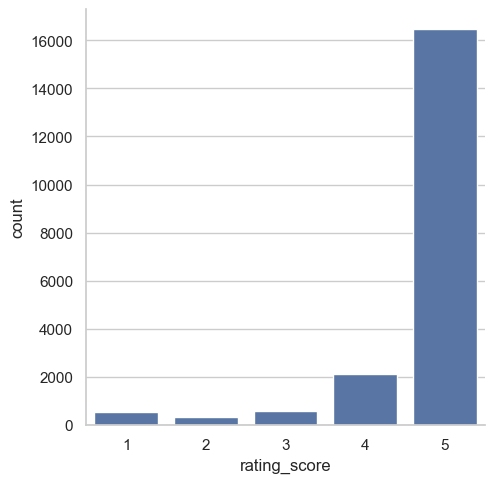

In [164]:
sns.catplot(rb, x='rating_score', kind='count')

<class 'pandas.core.frame.DataFrame'>


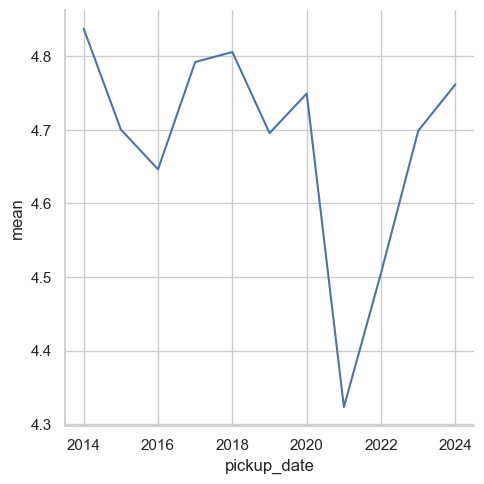

In [165]:
group=rb.groupby(rb['pickup_date'].dt.year)
g1=group.agg({'rating_score':['count', 'mean','sum', 'min', 'max', 'std']})
#g1['rating_score', 'sum']/g1['rating_score', 'count']
print(type(g1))
g1.columns= g1.columns.droplevel()

sns.relplot(data=g1, x='pickup_date', y='mean', kind="line")


<class 'pandas.core.frame.DataFrame'>


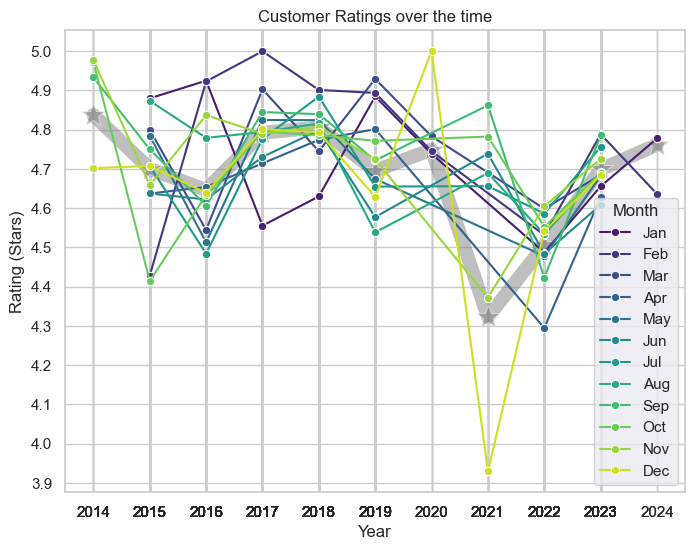

In [166]:
#-------------------
# Ratings Over Time
#___________________

#Data by year
group1=rb.groupby(rb['pickup_date'].dt.year)
g1=group1.agg({'rating_score':['count', 'mean','sum', 'min', 'max', 'std']})
#g1['rating_score', 'sum']/g1['rating_score', 'count']
print(type(g1))
g1.columns= g1.columns.droplevel()
g1.reset_index()
g1=g1[(g1['count']>=10)]

ax=sns.lineplot(data=g1, x='pickup_date', y='mean', color='#808080', linewidth=10, alpha=0.5, marker='*', markersize=18)

#Data by year and months
import datetime as dt
group2=rb.groupby([rb['pickup_date'].dt.year,rb['pickup_date'].dt.month])
g2=group2.agg({'rating_score':['count', 'mean','sum', 'min', 'max', 'std']})
g2.index.names=['year', 'month']
g2.columns= g2.columns.droplevel()
g2=g2.reset_index()
#converting numeric months to 3 letter months
g2['month']=g2['month'].apply(lambda x: dt.datetime.strptime(str(x),"%m").strftime("%b"))
#filtering out months with less than 10 values
g2=g2[(g2['count']>=10)]

#order for the hue
ordered_months=list(range(1,13))
ordered_month=map(lambda x: dt.datetime.strptime(str(x),"%m").strftime("%b") ,ordered_months)

sns.set(rc={'figure.figsize':(11.7,8.27)})

ax= sns.lineplot(data=g2, x='year', y='mean', hue='month', hue_order=ordered_month, marker='o', palette=sns.color_palette("viridis", n_colors=12)) #'Paired'

ax.set(xticks=g2['year'])
ax.set(yticks=np.arange(3.9, 5.1, .1))
plt.title('Customer Ratings over the time')
plt.legend(title='Month')
ax.set(xlabel='Year', ylabel='Rating (Stars)')

plt.show()

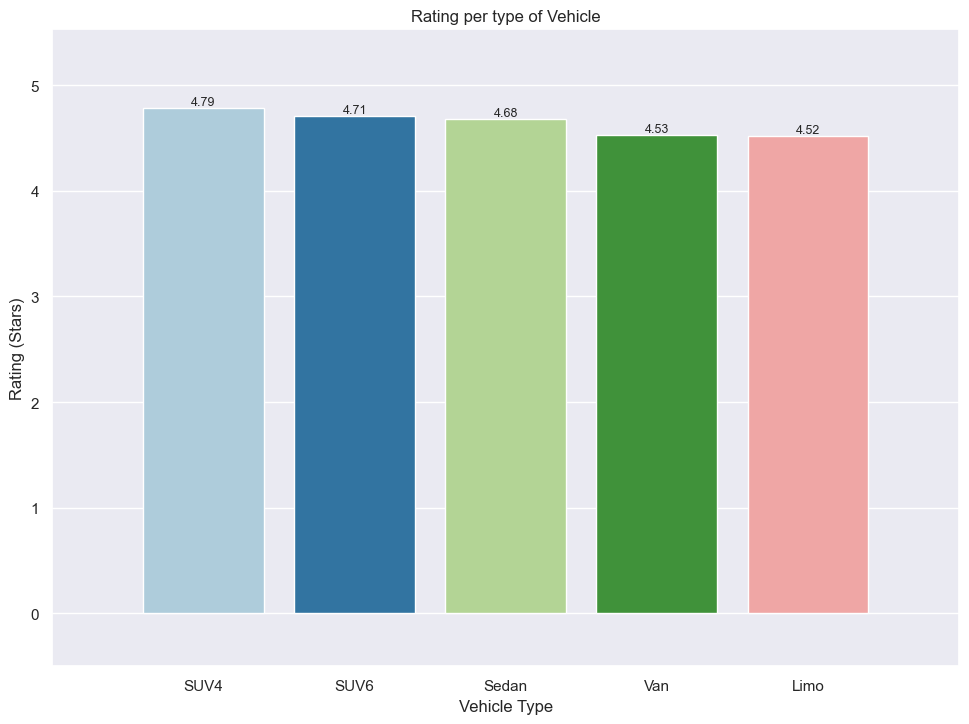

In [167]:
#Ratings by type of Vehicle

def add_margin(ax,x=0.05,y=0.05):
    # This will, by default, add 5% to the x and y margins. You 
    # can customise this using the x and y arguments when you call it.
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xmargin = (xlim[1]-xlim[0])*x
    ymargin = (ylim[1]-ylim[0])*y
    ax.set_xlim(xlim[0]-xmargin,xlim[1]+xmargin)
    ax.set_ylim(ylim[0]-ymargin,ylim[1]+ymargin)

group=rb.groupby(rb['vehicle_category'])
g1=group.agg({'rating_score':['count', 'mean','sum', 'min', 'max', 'std']})
g1.columns=g1.columns.droplevel(0)
g1=g1.reset_index()
g1=g1.sort_values(by=['mean'], ascending=False)

ax= sns.barplot(data=g1, x='vehicle_category',y='mean', hue='vehicle_category', palette=sns.color_palette("Paired", n_colors=5) )

#Set datalabels
sns.set(rc={'figure.figsize':(6,4.5)})
for i in ax.containers:
    ax.bar_label(i,fmt ='%.2f',fontsize=9)

# Update the limits using set_xlim and set_ylim
add_margin(ax,x=0.1,y=0.1) ### Call this after tsplot

#
plt.title('Rating per type of Vehicle')
#plt.legend(title='Month')
ax.set(xlabel='Vehicle Type', ylabel='Rating (Stars)')
plt.show()

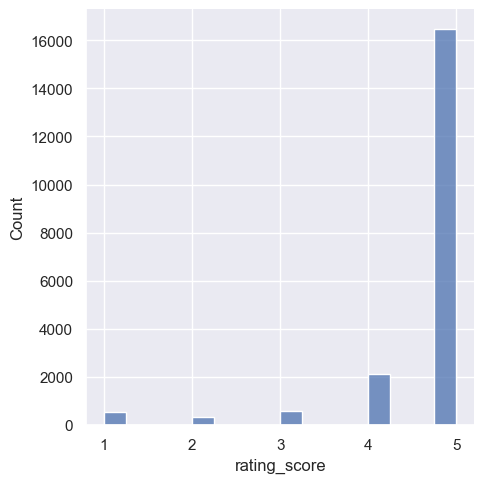

In [168]:
#Lat's see a distribution
sns.displot(rb['rating_score'])


#Meeeeeh!!

/usr/local/lib/python3.11/site-packages/plot_likert/plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)
/usr/local/lib/python3.11/site-packages/plot_likert/plot_likert.py:310: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  responses_to_first_question = responses_per_question[0]


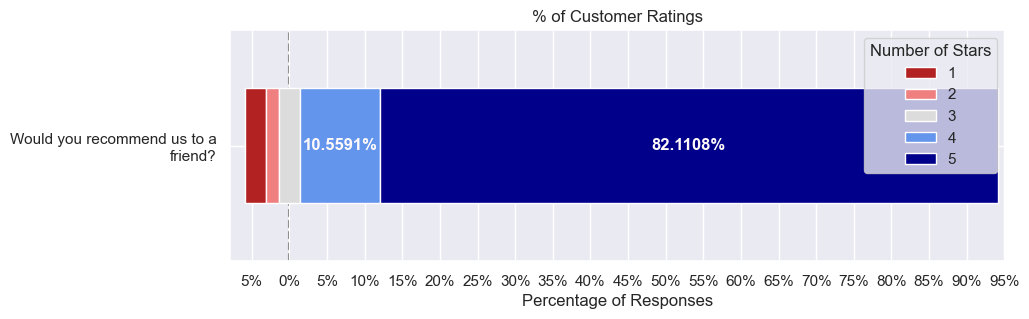

In [169]:
#Plot Likert
#!pip install plot-likert
#!python3.11 -m pip install --upgrade pip
import plot_likert
plot_likert.scales.agree
ratings={1:'Terrible',
         2:'Bad',
         3:'Whatever!',
         4:'Not bad at all',
         5:'Excellent'}
r=[1,2,3,4,5]

purpose_pd=pd.DataFrame({})
purpose_pd['Would you recommend us to a friend?']=rb['rating_score']

ax=plot_likert.plot_likert(purpose_pd['Would you recommend us to a friend?'], ratings , plot_percentage=True,bar_labels=True, bar_labels_color="snow", figsize=(10,3));
#ax.xaxis.set_label_text('% of Ratings');
plt.title('% of Customer Ratings')
plt.legend(title='Number of Stars')
#ax.set(xlabel='% of Ratings', ylabel='Would you recommend to a friend?')

#ax.figure.set_size_inches(12, 2)


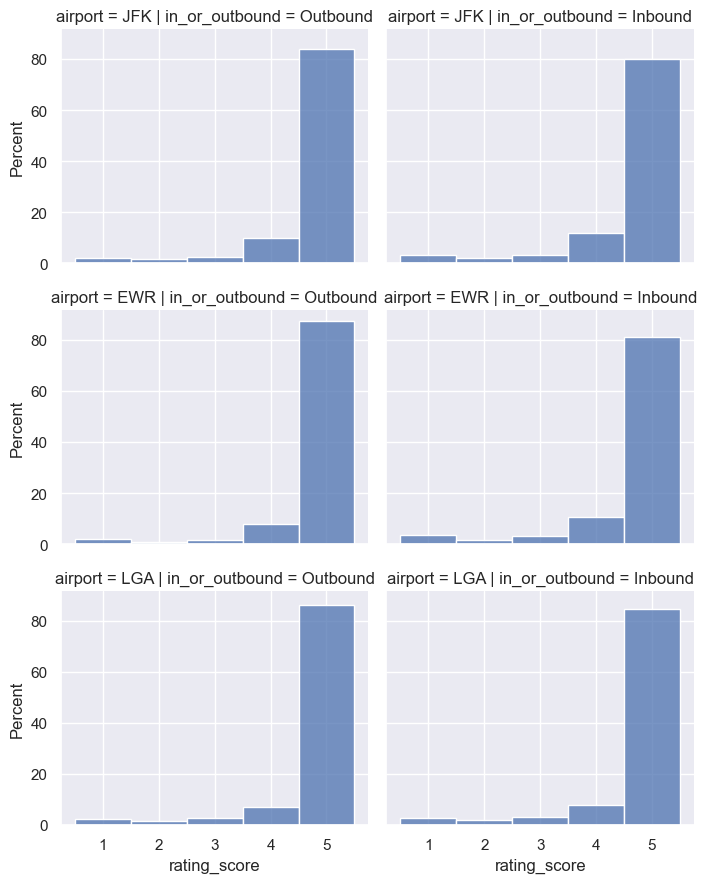

In [170]:
#See the Ratings compared for the airports and inbound/outbound
#Facets

g= sns.FacetGrid(rb, col='in_or_outbound', row='airport', height=3, aspect=1.2)
g.map_dataframe(sns.histplot, x='rating_score', stat='percent', discrete=True, fill=True)


#rating_grid = sns.FacetGrid(g, row = 'Airport', col = 'IN_or_OUTbound', palette = "Set2")
#rating_grid.map(sns.distplot,'Rating_value','Percentage')
#rating_grid.add_legend()

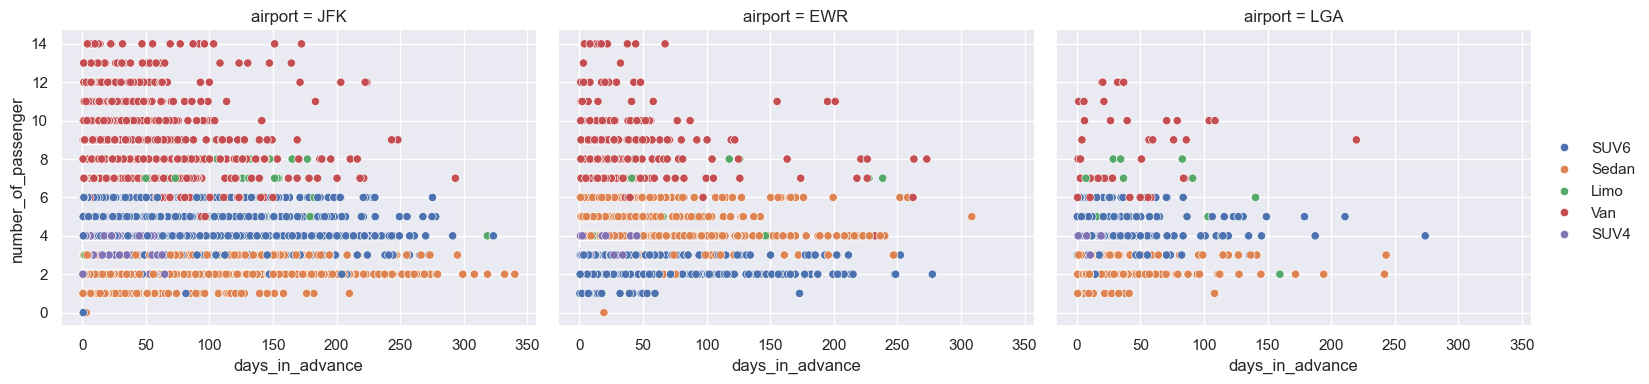

In [171]:
#Days in Advance / Number of Passengers
#Facets In/Out x Vehicle Type

g= sns.FacetGrid(rb[rb['number_of_passenger']<=15], col='airport', height=4, aspect=1.3)
g.map_dataframe(sns.scatterplot, x='days_in_advance', y='number_of_passenger', hue='vehicle_category')
g.add_legend()

#rating_grid = sns.FacetGrid(g, row = 'Airport', col = 'IN_or_OUTbound', palette = "Set2")
#rating_grid.map(sns.distplot,'Rating_value','Percentage')
#rating_grid.add_legend()




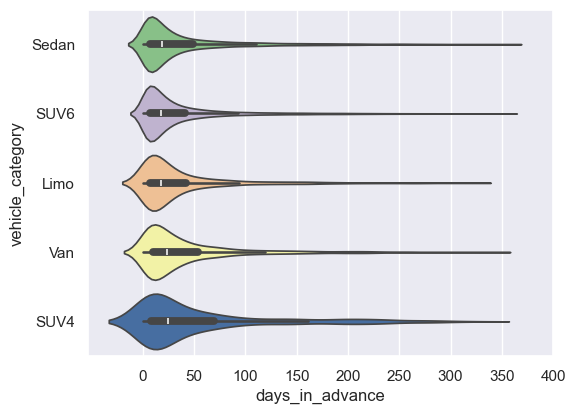

In [172]:
#Swarm PLot
#Days in Advance / Number of Passengers
#Facets In/Out x Vehicle Type

book_360=book[book['days_in_advance']<=360]

ax=sns.violinplot(book_360, x='days_in_advance', y='vehicle_category',hue='vehicle_category', palette='Accent')
ax.set(xticks=range(0,500,50))
sns.set(rc={'figure.figsize':(8,6)})
ax.set_xlim(xmax=400)
sns.set_theme(style='white')
#ax.set_xticks(range(0,500,50))

#ax.set_xticklabels(['A', 'B', 'C'])

#rating_grid = sns.FacetGrid(g, row = 'Airport', col = 'IN_or_OUTbound', palette = "Set2")
#rating_grid.map(sns.distplot,'Rating_value','Percentage')
#rating_grid.add_legend()




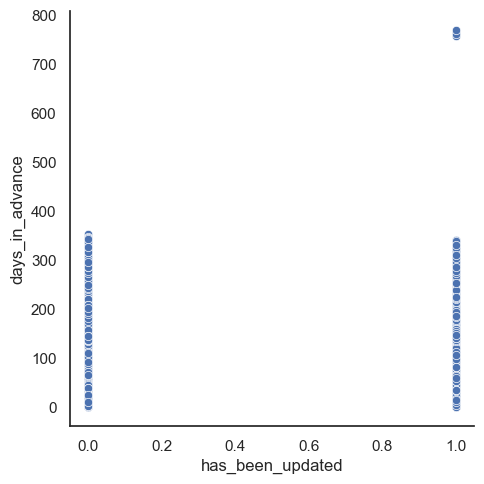

In [173]:
#Relationship between: Time in advance / Updating the booking

ax=sns.relplot(data=book, y='days_in_advance',x='has_been_updated')


<Axes: title={'center': 'rating_score'}, xlabel='vehicle_category'>

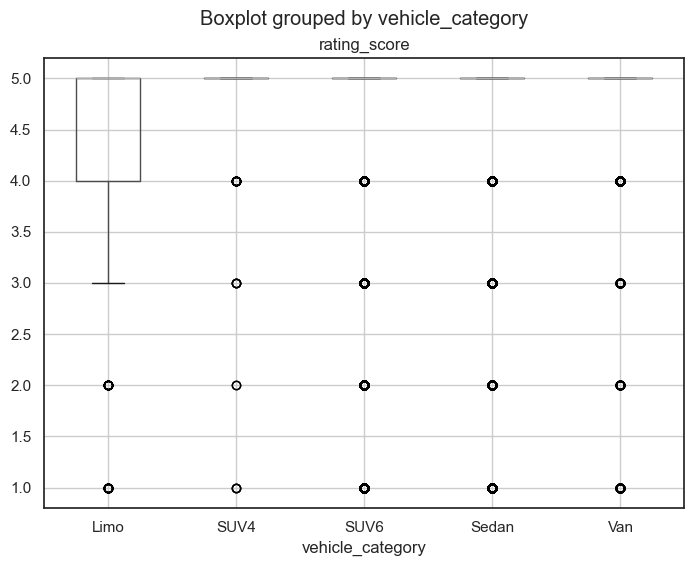

In [174]:
#Boxplot
rb.boxplot(by = 'vehicle_category', column = 'rating_score')


AttributeError: Can only use .dt accessor with datetimelike values

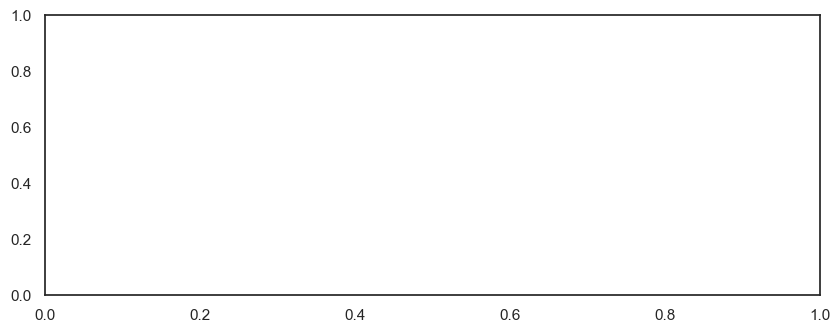

In [175]:
#Average #jobs per week and vehicle Y23 vs Y24 before and after SUV4
#Do not take this chart because it is not a fair comparisson.


f = plt.figure(figsize=(10,8))
gs = f.add_gridspec(2,1)

#Top Chart
#-----------------------
with sns.axes_style('white'):
    ax=f.add_subplot(gs[0,0])
#-----------------------
#Avg jobs per week by vehicle in 2022 and 2023.
group1=book[(book['pickup_date']>'2023/12/31')&(book['pickup_date']<'2024/02/01')].groupby([book['pickup_date'].dt.year, book['pickup_date'].dt.isocalendar().week, book['vehicle_category']])
g1=group1.agg({'booking_id':['count']})
g1.columns=g1.columns.droplevel(0)
g1=g1.reset_index()

#Boxplot
sns.boxplot(data=g1, x='count', hue='vehicle_category')

#Bottom Chart
###-----------------------------------------
with sns.axes_style('white'):
    ax1=f.add_subplot(gs[1,0])
#-----------------------
group2=book[(book['pickup_date']>'2022/12/31')&(book['pickup_date']<'2023/02/01')].groupby([book['pickup_date'].dt.year, book['pickup_date'].dt.isocalendar().week, book['vehicle_category']])
g2=group2.agg({'booking_id':['count']})
g2.columns=g2.columns.droplevel(0)
g2=g2.reset_index()

#Boxplot
sns.boxplot(data=g2, x='count', hue='vehicle_category')
    
# Plot the 2 charts together.
f.tight_layout()

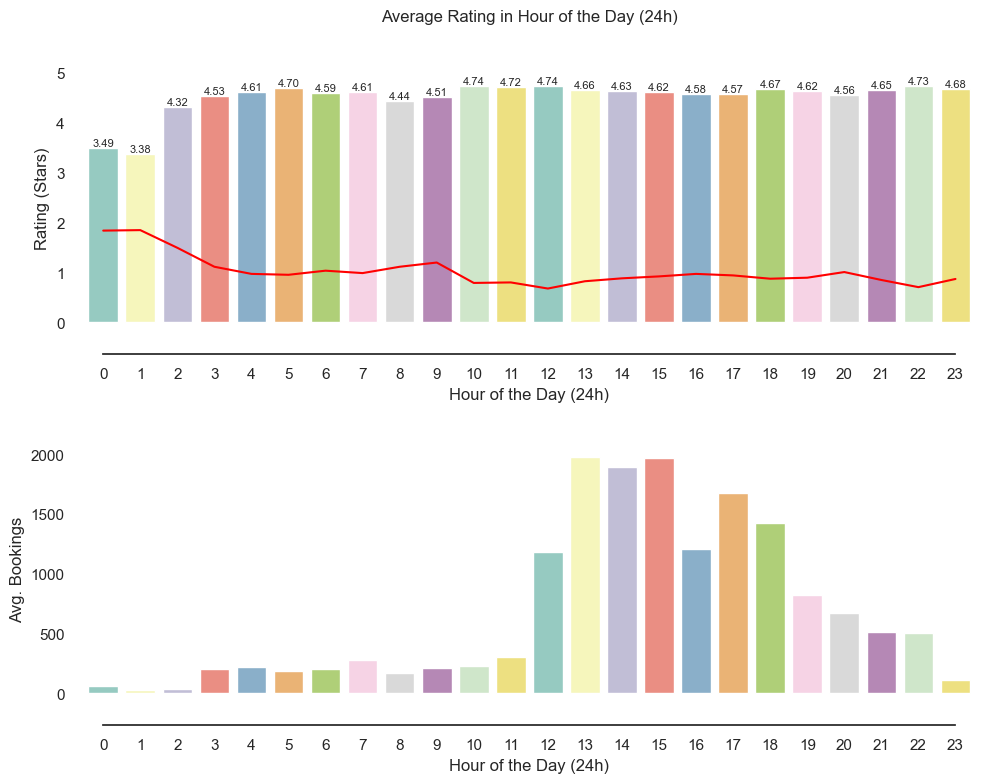

In [ ]:
#Ratings per Time of day.

f = plt.figure(figsize=(10,8))
gs = f.add_gridspec(2,1)

#Top Chart
#-----------------------
with sns.axes_style('white'):
    ax=f.add_subplot(gs[0,0])
#-----------------------
    def add_margin(ax,x=0.05,y=0.05):
        # This will, by default, add 5% to the x and y margins. You 
        # can customise this using the x and y arguments when you call it.
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xmargin = (xlim[1]-xlim[0])*x
        ymargin = (ylim[1]-ylim[0])*y
        ax.set_xlim(xlim[0]-xmargin,xlim[1]+xmargin)
        ax.set_ylim(ylim[0]-ymargin,ylim[1]+ymargin)


    rb['pickup_time'].apply(lambda x: str(x).split(':')[0]).value_counts()

    group=rb[ rb['pickup_date'].dt.year>=2022].groupby(rb['pickup_time'].apply(lambda x: int(str(x).split(':')[0])))
    g1=group.agg({'rating_score':['count', 'mean','sum', 'min', 'max', 'std']})
    #print(g1)
    g1.columns= g1.columns.droplevel()

    #sns.set_theme(style='whitegrid')
    sns.lineplot(data=g1,x='pickup_time', y='std', color='red')
    sns.barplot(data=g1, x='pickup_time', hue='pickup_time', legend='auto', y='mean', palette=sns.color_palette('Set3', n_colors=24))

    #Set datalabels
    #sns.set(rc={'figure.figsize':(10,5.5)})
    for i in ax.containers:
        ax.bar_label(i,fmt ='%.2f',fontsize=8)
    plt.title('Average Rating in Hour of the Day (24h)',pad=20)
    plt.legend()
    ax.set(xlabel='Hour of the Day (24h)', ylabel='Rating (Stars)')
    # Update the limits using set_xlim and set_ylim
    add_margin(ax,x=0.00,y=0.1) #Call this after tsplot

    sns.despine(offset=0, trim=True)
    sns.despine(left=True)

    plt.legend([],[], frameon=False)
    #plt.show()

#Bottom Chart
###-----------------------------------------
with sns.axes_style('white'):
    ax1=f.add_subplot(gs[1,0])
#-----------------------
    # Some additional preparations for the data.
    # More simple Vehicle by Category
    def func_case_vehicle(v):
        if v in ['Limo 8', 'SUV Limo', 'Limo 7']:
            return('Limo')
        if v in ['Sprinter 12', 'Van', 'Minibús de 20 plazas', 'Furgoneta de 14 plazas', 'Furgoneta de 10 plazas','Monovolumen de 7 plazas']:
            return('Van')
        else:
            return v

    book['vehicle_category']=book['vehicle_type'].apply(func_case_vehicle)
    #Convert to Datetimes
    book['pickup_date'] = pd.to_datetime(book['pickup_date'])

    #Make the data for the plot
    group=book[(book['pickup_date'].dt.year>=2022)&(book['pickup_date'].dt.year<2024)].groupby([book['pickup_time'].apply(lambda x: int(str(x).split(':')[0])), book['pickup_date'].dt.year])
    g1=group.agg({'booking_id':['count']})
    g1.columns= g1.columns.droplevel(0)
    g1=g1.reset_index()
    #print(g1)
    group2=g1.groupby([g1['pickup_time']], as_index=True)
    g2=group2.agg({'count':['mean']})
    g2.columns= g2.columns.droplevel(0)
    g2=g2.reset_index()
    sns.barplot(x=g2['pickup_time'],y=g2['mean'],hue=g2['pickup_time'] , palette=sns.color_palette('Set3', n_colors=24))
    plt.xticks(g2['pickup_time'])
    #plt.title('Average Bookings in each Hour of the Day (24h)')
    #plt.legend(title='Month')
    ax1.set(xlabel='Hour of the Day (24h)', ylabel='Avg. Bookings')
    # Update the limits using set_xlim and set_ylim
    add_margin(ax1,x=0.00,y=0.1) #Call this after tsplot
    ax1.axes.get_yaxis().set_visible(True)
    sns.despine(offset=5, trim=True)
    sns.despine(left=True)
    plt.legend([],[], frameon=False)
    #plt.show()
# Plot the 2 charts together.
f.tight_layout()

In [ ]:
#Inbound/Outbound - 'in_or_outbound'
#Airport - 'airport'
# # Of bookings
# Avg. Ratings
# Avg. Ratings with 1 or 2 stars.






In [ ]:
# More simple Vehicle by Category

def func_case_vehicle(v):
    if v in ['Limo 8', 'SUV Limo', 'Limo 7']:
        return('Limo')
    if v in ['Sprinter 12', 'Van', 'Minibús de 20 plazas', 'Furgoneta de 14 plazas', 'Furgoneta de 10 plazas','Monovolumen de 7 plazas']:
        return('Van')
    else:
        return v

book['vehicle_category']=book['vehicle_type'].apply(func_case_vehicle)

#Convert to Datetimes
book['pickup_date'] = pd.to_datetime(book['pickup_date'])


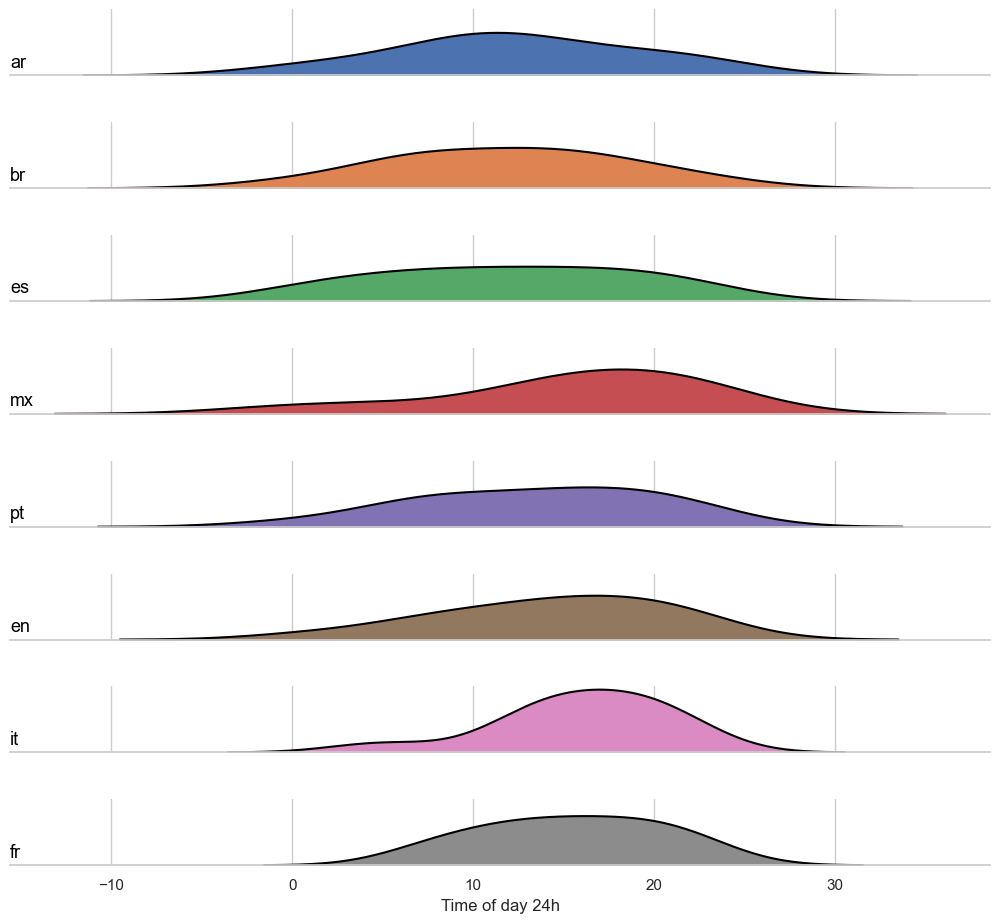

In [ ]:
#Country and #jobs per time of the day.
group=rb[(rb['pickup_date'].dt.year.isin([2023,2024]))&(rb['in_or_outbound']=='Inbound')].groupby([rb['pickup_time'].apply(lambda x: int(str(x).split(':')[0])), rb['country']])
g=group.agg({'booking_id':['count']})
g.columns= g.columns.droplevel(0)
g=g.reset_index()

#rb['in_or_outbound'] = rb['in_or_outbound'].astype('category')

sns.set_theme(style='whitegrid')
graphic = sns.FacetGrid(data=g, row='country',aspect=9, height=1.2, hue='country')

graphic.map_dataframe(sns.kdeplot, x='pickup_time',  fill=True, alpha=1)
graphic.map_dataframe(sns.kdeplot, x='pickup_time',  color='black')
graphic.set_titles=('')
graphic.figure.subplots_adjust(hspace=-0.5)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
graphic.map(label, 'country')

graphic.set(yticks=[], xlabel='Time of day 24h',ylabel=None, title=None)
graphic.despine(left=True)

# sns.lineplot(data=g1,x='pickup_time', y='std', color='red')
#sns.barplot(data=g1, x='pickup_time', hue='pickup_time', legend='auto', y='mean', palette=sns.color_palette('Set3', n_colors=24))


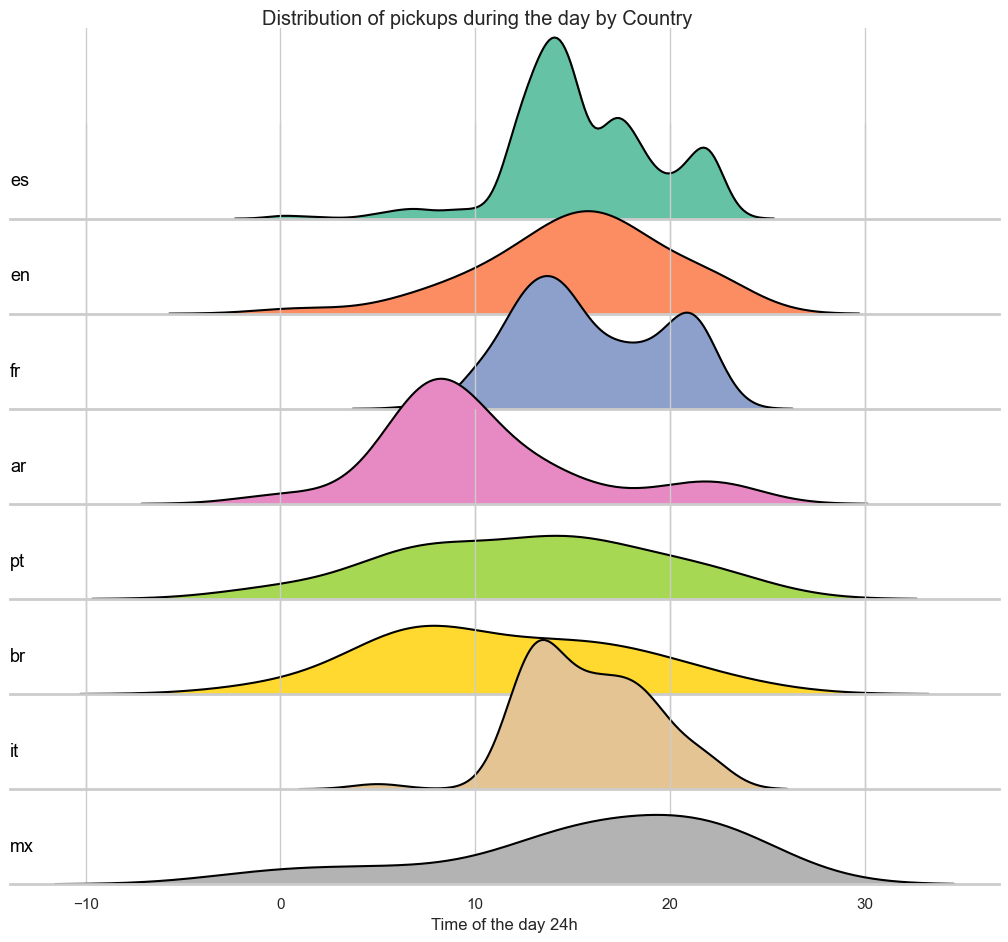

In [244]:

#Distribution of reservations in the hours of the day by Country

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

rb['pickup_hour']=rb['pickup_time'].apply(lambda x: int(str(x).split(':')[0]))

# Theme
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)

# create a grid with a row for each 'Language'
g = sns.FacetGrid(rb[(rb['pickup_date'].dt.year.isin([2023,2024]))&(rb['in_or_outbound']=='Inbound')], palette=palette, row="country", hue="country", aspect=9, height=1.2)

# map df - Kernel Density Plot of IMDB Score for each Language
g.map_dataframe(sns.kdeplot, x="pickup_hour", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="pickup_hour", color='black')

# function to draw labels
def label(x, color, label):
    ax = plt.gca() #get current axis
    
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
# iterate grid to plot labels
g.map(label, "country")

# adjust subplots to create overlap
g.fig.subplots_adjust(hspace=-.5)

# remove subplot titles
g.set_titles("")
# remove yticks and set xlabel
g.set(yticks=[], xlabel="Time of the day 24h", ylabel="")
# remove left spine
g.despine(left=True)
# set title
plt.suptitle('Distribution of pickups during the day by Country', y=0.98)


plt.savefig('ridgeplot.png')

In [245]:

#Distribution of reservations in the hours of the day by city_of_departure

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
rb['pickup_hour']=rb['pickup_time'].apply(lambda x: int(str(x).split(':')[0]))

# Theme
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)

# create a grid with a row for each 'Language'
g = sns.FacetGrid(rb[(rb['pickup_date'].dt.year.isin([2023,2024]))&(rb['in_or_outbound']=='Inbound')], palette=palette, row='city_of_departure', hue="city_of_departure", aspect=9, height=1)

# map df - Kernel Density Plot of IMDB Score for each Language
g.map_dataframe(sns.kdeplot, x="pickup_hour", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="pickup_hour", color='black')

# function to draw labels
def label(x, color, label):
    ax = plt.gca() #get current axis
    
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
# iterate grid to plot labels
g.map(label, "city_of_departure")

# adjust subplots to create overlap
g.fig.subplots_adjust(hspace=-.5)

# remove subplot titles
g.set_titles("")
# remove yticks and set xlabel
g.set(yticks=[], xlabel="Time of the day 24h", ylabel="")
# remove left spine
g.despine(left=True)
# set title
plt.suptitle('Distribution of pickups during the day by City of Departure', y=0.98)


plt.savefig('ridgeplot.png')

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x11d5a9ee0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

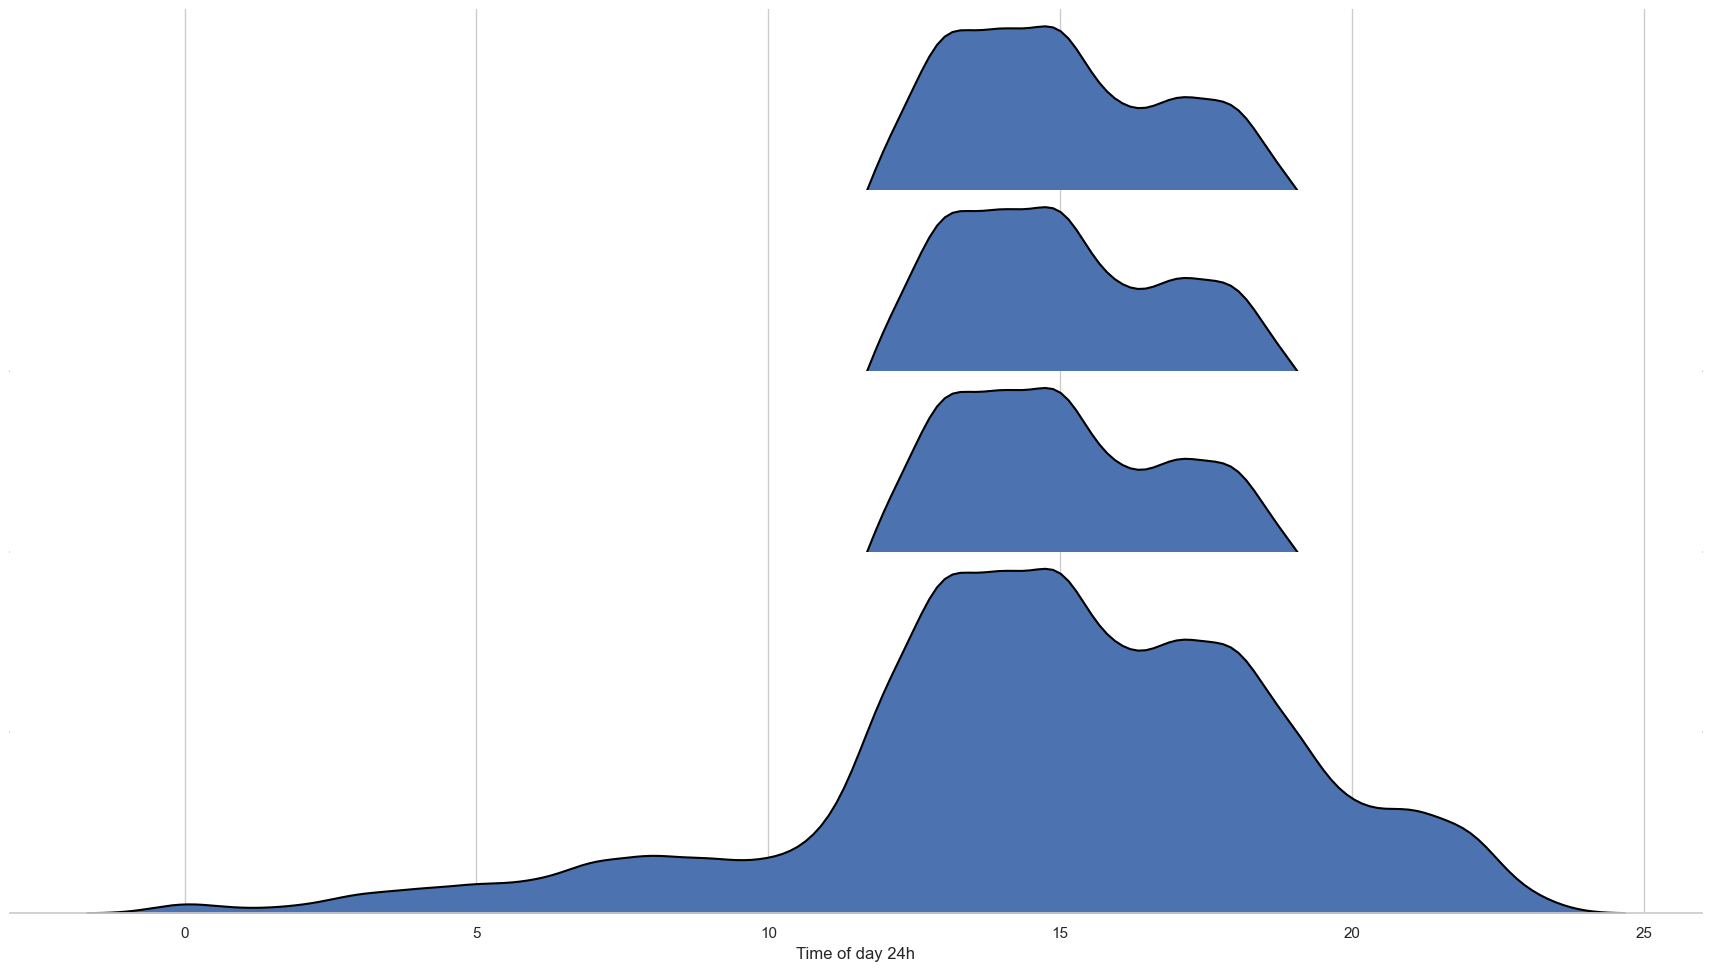

In [199]:
#Country and #jobs per time of the day.

sns.set_theme(style='whitegrid')
graphic = sns.FacetGrid(data=rb, row='zone_departure',aspect=6, height=3)

graphic.map_dataframe(sns.kdeplot, x=rb['pickup_time'].apply(lambda x: int(str(x).split(':')[0])),  fill=True, alpha=1)
graphic.map_dataframe(sns.kdeplot, x=rb['pickup_time'].apply(lambda x: int(str(x).split(':')[0])),  color='black')
graphic.set_titles=('')
graphic.figure.subplots_adjust(hspace=-0.5)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
#graphic.map(label, rb[~(rb['zone_departure']isna())])

graphic.set(yticks=[], xlabel='Time of day 24h',ylabel=None, title=None)
graphic.despine(left=True)

# sns.lineplot(data=g1,x='pickup_time', y='std', color='red')
#sns.barplot(data=g1, x='pickup_time', hue='pickup_time', legend='auto', y='mean', palette=sns.color_palette('Set3', n_colors=24))


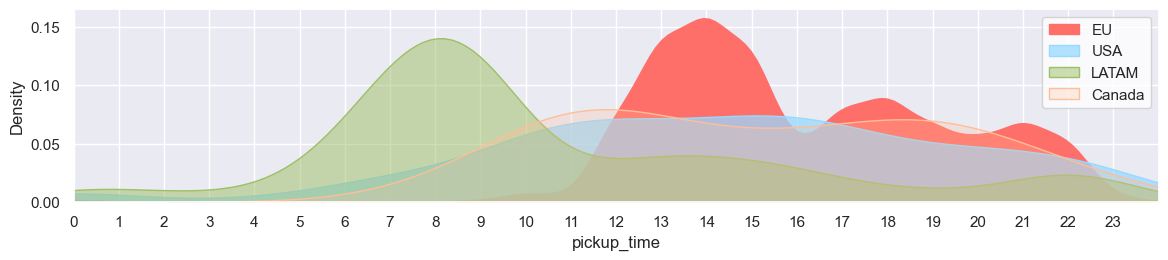

In [227]:
sns.set(rc={'figure.figsize':(14,2.5)})
sns.kdeplot(x=rb[rb['zone_departure']=='EU']['pickup_time'].apply(lambda x: int(str(x).split(':')[0])), fill=True, alpha=1, color='#ff6f69')
sns.kdeplot(x=rb[rb['zone_departure']=='USA']['pickup_time'].apply(lambda x: int(str(x).split(':')[0])), fill=True, alpha=.75, color='#98d9ff')
sns.kdeplot(x=rb[rb['zone_departure']=='LATAM']['pickup_time'].apply(lambda x: int(str(x).split(':')[0])), fill=True, alpha=.50,color='#9ebf65')
ax=sns.kdeplot(x=rb[rb['zone_departure']=='Canada']['pickup_time'].apply(lambda x: int(str(x).split(':')[0])), fill=True, alpha=.25, color='#ffbe98')
ax.set_xlim(xmax=24)
ax.set_xlim(xmin=0)
sns.set_theme(style='white')
ax.set_xticks(range(0,24,1))
plt.legend(["EU","USA","LATAM","Canada"])


In [ ]:
#Country and #jobs per time of the day.
group=rb[rb['in_or_outbound']=='Inbo'].groupby([rb['pickup_time'].apply(lambda x: int(str(x).split(':')[0])), rb['country']])
g=group.agg({'booking_id':['count']})
g.columns= g.columns.droplevel(0)
g=g.reset_index()
g[g['pickup_time']==8]

,pickup_time,country,count
29,8,ar,14
30,8,br,1
31,8,en,5
32,8,es,228
33,8,fr,1
34,8,pt,2


In [ ]:
#Number of jobs


In [ ]:
#By supplier

In [ ]:
#Time ahead of the reservation

In [ ]:
#Reservations that had updates or not.

In [ ]:
#Country

In [ ]:
#Address

In [ ]:
rb['pickup_time']

0        21:00
1        22:35
2        13:50
3        18:30
4        03:00
         ...  
20063    04:00
20064    16:00
20065    19:00
20066    17:10
20067    18:55
Name: pickup_time, Length: 20068, dtype: object